In [16]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dot, Add, Flatten
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD, Adamax
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

In [2]:
r_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv('/content/drive/MyDrive/recomm_sample/u.data.csv', names=r_cols,  sep='\t',encoding='latin-1')
ratings = ratings[['user_id', 'movie_id', 'rating']].astype(int)  
print(ratings.shape) 
ratings.head()

(100000, 3)


,user_id,movie_id,rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1


In [3]:
# train_test shuffle
train_size = 0.75
ratings = shuffle(ratings)
cutoff = int(train_size * len(ratings))
ratings_train = ratings.iloc[:cutoff]
ratings_test = ratings.iloc[cutoff:]
print(len(ratings_train))
print(len(ratings_test))

75000
25000


# 1. Tensorflow로 만드는 MF

In [4]:
# variables
k = 200  # 잠재요인 k
mu = ratings_train['rating'].mean()
m = ratings_train['user_id'].max() + 1  # user 수
n = ratings_train['movie_id'].max() + 1  # item 수
print(mu,'\n',m,'\n',n)

3.5318666666666667 
 944 
 1683


In [5]:
def rmse(y_true,y_pred):
  return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))   # tensorflow에 포함된 square(제곱), reduce_mean(평균), sqrt(제곱근)

# Embedding 및 Bias Embedding 과정
user = Input(shape=(1, ))                                               # User input
item = Input(shape=(1, ))                                               # Item input
p_embedding = Embedding(m, k, embeddings_regularizer=l2())(user)        # (M, 1, K)
q_embedding = Embedding(n, k, embeddings_regularizer=l2())(item)        # (N, 1, K)
user_bias = Embedding(m, 1, embeddings_regularizer=l2())(user)          # User bias term (M, 1, )
item_bias = Embedding(n, 1, embeddings_regularizer=l2())(item) 

# 내적 ~ Flatten
r = layers.dot([p_embedding,q_embedding],axes=2)
r = layers.add([r, user_bias, item_bias])
r = layers.Flatten()(r)

In [6]:
# Model Setting
model = Model(inputs=[user,item], outputs = r)
model.compile(loss=rmse, optimizer=SGD(), metrics=[rmse])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1, 200)       188800      ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 1, 200)       336600      ['input_2[0][0]']                
                                                                                              

In [7]:
# model training
result = model.fit(
    x = [ratings_train['user_id'].values, ratings_train['movie_id'].values],
    y = ratings_train['rating'].values - mu, 
    epochs=60, batch_size=256, 
    validation_data = ([ratings_test['user_id'].values, ratings_test['movie_id'].values],
                       ratings_test['rating'].values - mu)
)

# 전체 평균 빼는 이유? --> 전체 평균을 모델화 하는게 매우 복잡 --> 각 rating에서 전체 평균 빼주고 나중 예측치 낼때 전체 평균을 더해주자!

Epoch 1/60
293/293 [==============================] - 7s 10ms/step - loss: 5.2730 - rmse: 1.1229 - val_loss: 5.0398 - val_rmse: 1.1288
Epoch 2/60
293/293 [==============================] - 3s 9ms/step - loss: 4.8120 - rmse: 1.1208 - val_loss: 4.6054 - val_rmse: 1.1269
Epoch 3/60
293/293 [==============================] - 2s 8ms/step - loss: 4.4019 - rmse: 1.1189 - val_loss: 4.2191 - val_rmse: 1.1251
Epoch 4/60
293/293 [==============================] - 2s 7ms/step - loss: 4.0373 - rmse: 1.1172 - val_loss: 3.8756 - val_rmse: 1.1235
Epoch 5/60
293/293 [==============================] - 2s 8ms/step - loss: 3.7131 - rmse: 1.1156 - val_loss: 3.5701 - val_rmse: 1.1220
Epoch 6/60
293/293 [==============================] - 3s 9ms/step - loss: 3.4247 - rmse: 1.1141 - val_loss: 3.2984 - val_rmse: 1.1206
Epoch 7/60
293/293 [==============================] - 3s 10ms/step - loss: 3.1683 - rmse: 1.1128 - val_loss: 3.0567 - val_rmse: 1.1193
Epoch 8/60
293/293 [==============================] - 3s 10m

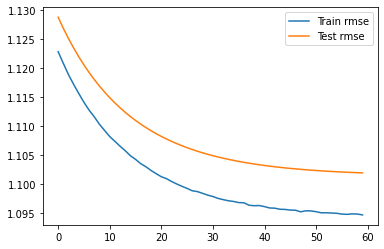

In [8]:
plt.plot(result.history['rmse'], label='Train rmse')
plt.plot(result.history['val_rmse'], label='Test rmse')
plt.legend()
plt.show()

In [9]:
# 결과 Prediction
user_ids = ratings_test['user_id'].values[0:6]
item_ids = ratings_test['movie_id'].values[0:6]
predictions = model.predict([user_ids,item_ids]) + mu
print('Actuals : \n', ratings_test[0:6],'\n')
print('Predictions : \n',predictions)

Actuals : 
        user_id  movie_id  rating
31830      194        73       3
88214      181      1215       1
37551       85       813       4
20659      346       302       3
69408      650       482       3
75389      773       431       1 

Predictions : 
 [[3.460263 ]
 [3.1796043]
 [3.54147  ]
 [3.59207  ]
 [3.5041294]
 [3.5065553]]


In [10]:
# MF신경망의 RMSE 값 체크
def rmse_2(y_true,y_pred):
  return np.sqrt(np.mean((np.array(y_true) - np.array(y_pred)) ** 2))

user_ids = ratings_test['user_id'].values
item_ids = ratings_test['movie_id'].values
y_pred = model.predict([user_ids,item_ids]) + mu
print(y_pred.shape) # 25000 * 1 배열
y_pred = np.ravel(y_pred,order='C') # np.ravel : reshape함수와 유사한 역할 --> 다차원 array를 1차원 array로 변형하는 역할
print(y_pred.shape)  # 1차원 배열로 변환
y_true = np.array(ratings_test['rating'])

results = rmse_2(y_true,y_pred)
print(results)

(25000, 1)
(25000,)
1.1028082799074108


# 2. Dense Layer 추가된 추천시스템 모델

In [11]:
from tensorflow.keras.layers import Dense, Concatenate, Activation

user = Input(shape=(1, ))                                               # User input
item = Input(shape=(1, ))                                               # Item input
p_embedding = Embedding(m, k, embeddings_regularizer=l2())(user)        # (M, 1, K)
q_embedding = Embedding(n, k, embeddings_regularizer=l2())(item)        # (N, 1, K)
user_bias = Embedding(m, 1, embeddings_regularizer=l2())(user)          # User bias term (M, 1, )
item_bias = Embedding(n, 1, embeddings_regularizer=l2())(item) 

# 4개의 embedding 연결(Concatenate)
p_embedding = Flatten()(p_embedding)  # concatenate를 위해 1차원으로 Flatten
q_embedding = Flatten()(q_embedding)
user_bias = Flatten()(user_bias)
item_bias = Flatten()(item_bias)
r = Concatenate()([p_embedding, q_embedding, user_bias, item_bias])   # concatenate의 노드수 402(p:200,q:200,ub=1,ib=1)

# Dense Layer
r = Dense(2048)(r)
r = Activation('linear')(r)
r = Dense(256)(r)
r = Activation('linear')(r)
r = Dense(1)(r)

model = Model(inputs=[user, item], outputs=r)
model.compile(loss=rmse, optimizer=SGD(), metrics=[rmse])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding_4 (Embedding)        (None, 1, 200)       188800      ['input_3[0][0]']                
                                                                                                  
 embedding_5 (Embedding)        (None, 1, 200)       336600      ['input_4[0][0]']                
                                                                                            

In [12]:
# model train
result_2 = model.fit(x=[ratings_train['user_id'].values, ratings_train['movie_id'].values],
                   y=ratings_train['rating'].values - mu,
                   epochs=65, batch_size=512,
                   validation_data = ([ratings_test['user_id'].values,ratings_test['movie_id'].values],
                                      ratings_test['rating'].values - mu
                                      )
                   )

Epoch 1/65
147/147 [==============================] - 2s 10ms/step - loss: 5.4018 - rmse: 1.1238 - val_loss: 5.2830 - val_rmse: 1.1309
Epoch 2/65
147/147 [==============================] - 1s 8ms/step - loss: 5.1560 - rmse: 1.1223 - val_loss: 5.0442 - val_rmse: 1.1292
Epoch 3/65
147/147 [==============================] - 1s 8ms/step - loss: 4.9241 - rmse: 1.1208 - val_loss: 4.8191 - val_rmse: 1.1276
Epoch 4/65
147/147 [==============================] - 1s 8ms/step - loss: 4.7056 - rmse: 1.1193 - val_loss: 4.6074 - val_rmse: 1.1266
Epoch 5/65
147/147 [==============================] - 1s 8ms/step - loss: 4.4995 - rmse: 1.1181 - val_loss: 4.4070 - val_rmse: 1.1249
Epoch 6/65
147/147 [==============================] - 1s 8ms/step - loss: 4.3052 - rmse: 1.1168 - val_loss: 4.2184 - val_rmse: 1.1236
Epoch 7/65
147/147 [==============================] - 1s 8ms/step - loss: 4.1218 - rmse: 1.1154 - val_loss: 4.0402 - val_rmse: 1.1219
Epoch 8/65
147/147 [==============================] - 1s 8ms/

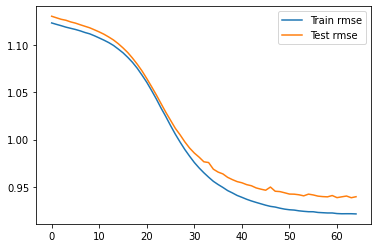

In [13]:
plt.plot(result_2.history['rmse'], label='Train rmse')
plt.plot(result_2.history['val_rmse'], label='Test rmse')
plt.legend()
plt.show()

In [24]:
# 변수를 추가한 딥러닝 모델
# user 데이터셋의 Occupation(직업) 컬럼과 영화선택 간 차이가 있다고 가정

u_cols = ['user_id','age','sex','occupation','zip_code']
users = pd.read_csv('/content/drive/MyDrive/recomm_sample/u.user.csv',sep='|',names=u_cols,
                    encoding='latin_1')
users = users[['user_id','occupation']]

le = LabelEncoder()
users['occupation'] = le.fit_transform(users['occupation']) # int형으로 직업 변경
print(users.head())
l = users['occupation'].max() + 1
print(l)

   user_id  occupation
0        1          19
1        2          13
2        3          20
3        4          19
4        5          13
21


In [28]:
# ratings 데이터셋과 merge 이후 occupation 부분만 따로 추출
train_occ = pd.merge(ratings_train,users,on='user_id')['occupation']
test_occ = pd.merge(ratings_test,users,on='user_id')['occupation']
print(train_occ)
print(test_occ)

0        18
1        18
2        18
3        18
4        18
         ..
74995    14
74996    14
74997    14
74998    14
74999    14
Name: occupation, Length: 75000, dtype: int64
0         0
1         0
2         0
3         0
4         0
         ..
24995    11
24996    11
24997    11
24998    11
24999    11
Name: occupation, Length: 25000, dtype: int64


In [29]:
user = Input(shape=(1, ))                                               
item = Input(shape=(1, ))                                               
occ = Input(shape=(1, ))      # occ input
p_embedding = Embedding(m, k, embeddings_regularizer=l2())(user)        
q_embedding = Embedding(n, k, embeddings_regularizer=l2())(item)        
occ_embedding = Embedding(l, 3, embeddings_regularizer=l2())(occ)    # occupation의 잠재요인은 일단 3개로!
user_bias = Embedding(m, 1, embeddings_regularizer=l2())(user)          
item_bias = Embedding(n, 1, embeddings_regularizer=l2())(item) 

# 4개의 embedding 연결(Concatenate)
p_embedding = Flatten()(p_embedding)  
q_embedding = Flatten()(q_embedding)
occ_layer = Flatten()(occ_embedding)
user_bias = Flatten()(user_bias)
item_bias = Flatten()(item_bias)
r = Concatenate()([p_embedding, q_embedding, user_bias, item_bias, occ_layer])   # concatenate의 노드수 402(p:200,q:200,ub=1,ib=1)

r = Dense(2048)(r)
r = Activation('linear')(r)
r = Dense(256)(r)
r = Activation('linear')(r)
r = Dense(1)(r)

model = Model(inputs=[user, item, occ], outputs=r)
model.compile(loss=rmse, optimizer=SGD(), metrics=[rmse])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_7 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding_8 (Embedding)        (None, 1, 200)       188800      ['input_5[0][0]']                
                                                                                            

In [32]:
result_3 = model.fit(
    x=[ratings_train['user_id'].values, ratings_train['movie_id'].values, train_occ.values],
    y=ratings_train['rating'].values - mu,
    epochs=65, batch_size=512,
    validation_data = ([ratings_test['user_id'].values, ratings_test['movie_id'].values, test_occ.values],
                       ratings_test['rating'].values - mu
                       )
)

Epoch 1/65
147/147 [==============================] - 2s 13ms/step - loss: 3.4321 - rmse: 1.1020 - val_loss: 3.3695 - val_rmse: 1.1075
Epoch 2/65
147/147 [==============================] - 2s 13ms/step - loss: 3.2963 - rmse: 1.0986 - val_loss: 3.2373 - val_rmse: 1.1039
Epoch 3/65
147/147 [==============================] - 2s 12ms/step - loss: 3.1675 - rmse: 1.0944 - val_loss: 3.1121 - val_rmse: 1.0997
Epoch 4/65
147/147 [==============================] - 2s 13ms/step - loss: 3.0454 - rmse: 1.0899 - val_loss: 2.9933 - val_rmse: 1.0951
Epoch 5/65
147/147 [==============================] - 2s 13ms/step - loss: 2.9295 - rmse: 1.0853 - val_loss: 2.8804 - val_rmse: 1.0896
Epoch 6/65
147/147 [==============================] - 2s 13ms/step - loss: 2.8192 - rmse: 1.0791 - val_loss: 2.7729 - val_rmse: 1.0833
Epoch 7/65
147/147 [==============================] - 2s 12ms/step - loss: 2.7142 - rmse: 1.0721 - val_loss: 2.6710 - val_rmse: 1.0767
Epoch 8/65
147/147 [==============================] - 2

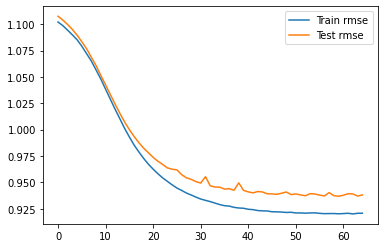

In [33]:
plt.plot(result_3.history['rmse'], label='Train rmse')
plt.plot(result_3.history['val_rmse'], label='Test rmse')
plt.legend()
plt.show()

In [54]:
# 나이 데이터를 변수로 추가하기

u_cols = ['user_id','age','sex','occupation','zip_code']
users = pd.read_csv('/content/drive/MyDrive/recomm_sample/u.user.csv',sep='|',names=u_cols,
                    encoding='latin_1')
users = users[['user_id','occupation','age']]

le = LabelEncoder()
users['occupation'] = le.fit_transform(users['occupation']) # int형으로 직업 변경
print(users.head())
l = users['occupation'].max() + 1  # 21
a = len(users['age'].unique())    # 61

# ratings 데이터셋과 merge
train_occ = pd.merge(ratings_train,users,on='user_id')['occupation']
test_occ = pd.merge(ratings_test,users,on='user_id')['occupation']
train_age = pd.merge(ratings_train,users,on='user_id')['age']
test_age = pd.merge(ratings_test,users,on='user_id')['age']

user = Input(shape=(1, ))                                               
item = Input(shape=(1, ))                                               
occ = Input(shape=(1, ))     # occ input
age = Input(shape=(1, ))     # age input
p_embedding = Embedding(m, k, embeddings_regularizer=l2())(user)        
q_embedding = Embedding(n, k, embeddings_regularizer=l2())(item)        
occ_embedding = Embedding(l, 3, embeddings_regularizer=l2())(occ)    # occupation의 잠재요인은 일단 3개로!
age_embedding = Embedding(a,10, embeddings_regularizer=l2())(age)
user_bias = Embedding(m, 1, embeddings_regularizer=l2())(user)          
item_bias = Embedding(n, 1, embeddings_regularizer=l2())(item) 

# 4개의 embedding 연결(Concatenate)
p_embedding = Flatten()(p_embedding)  
q_embedding = Flatten()(q_embedding)
occ_layer = Flatten()(occ_embedding)
age_layer = layers.LSTM(32)(age_embedding)
#age_layer = Flatten()(age_embedding)
user_bias = Flatten()(user_bias)
item_bias = Flatten()(item_bias)
r = Concatenate()([p_embedding, q_embedding, user_bias, item_bias, occ_layer,age_layer])   # concatenate의 노드수 402(p:200,q:200,ub=1,ib=1)

r = Dense(2048)(r)
r = Activation('linear')(r)
r = Dense(256)(r)
r = Activation('linear')(r)
r = Dense(1)(r)

model = Model(inputs=[user, item, occ, age], outputs=r)
model.compile(loss=rmse, optimizer=SGD(), metrics=[rmse])
model.summary()

   user_id  occupation  age
0        1          19   24
1        2          13   53
2        3          20   23
3        4          19   24
4        5          13   33
Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_44 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_45 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_46 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_47 (InputLayer) 

In [55]:
result_4 = model.fit(
    x=[ratings_train['user_id'].values, ratings_train['movie_id'].values, train_occ.values, train_age.values],
    y=ratings_train['rating'].values - mu,
    epochs=65, batch_size=512,
    validation_data = ([ratings_test['user_id'].values, ratings_test['movie_id'].values, test_occ.values, test_age.values],
                       ratings_test['rating'].values - mu
                       )
)

Epoch 1/65
147/147 [==============================] - 7s 18ms/step - loss: 5.4029 - rmse: 1.1232 - val_loss: 5.2826 - val_rmse: 1.1290
Epoch 2/65
147/147 [==============================] - 2s 14ms/step - loss: 5.1564 - rmse: 1.1215 - val_loss: 5.0435 - val_rmse: 1.1271
Epoch 3/65
147/147 [==============================] - 2s 13ms/step - loss: 4.9242 - rmse: 1.1195 - val_loss: 4.8182 - val_rmse: 1.1253
Epoch 4/65
147/147 [==============================] - 2s 13ms/step - loss: 4.7053 - rmse: 1.1177 - val_loss: 4.6055 - val_rmse: 1.1234
Epoch 5/65
147/147 [==============================] - 2s 14ms/step - loss: 4.4987 - rmse: 1.1158 - val_loss: 4.4051 - val_rmse: 1.1216
Epoch 6/65
147/147 [==============================] - 2s 14ms/step - loss: 4.3038 - rmse: 1.1137 - val_loss: 4.2161 - val_rmse: 1.1199
Epoch 7/65
147/147 [==============================] - 2s 14ms/step - loss: 4.1200 - rmse: 1.1119 - val_loss: 4.0374 - val_rmse: 1.1177
Epoch 8/65
147/147 [==============================] - 2

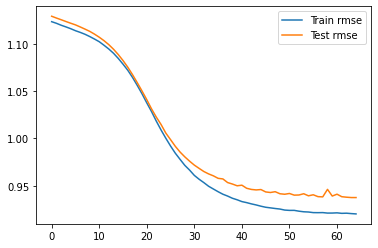

In [56]:
plt.plot(result_4.history['rmse'], label='Train rmse')
plt.plot(result_4.history['val_rmse'], label='Test rmse')
plt.legend()
plt.show()

In [57]:
# 추천 결과 Prediction
user_ids = ratings_test['user_id'].values[0:6]
item_ids = ratings_test['movie_id'].values[0:6]
occ_ids = test_occ.values[0:6]
age_ids = test_age.values[0:6]
predictions = model.predict([user_ids,item_ids,occ_ids,age_ids]) + mu
print('Actuals : \n', ratings_test[0:6],'\n')
print('Predictions : \n',predictions)

Actuals : 
        user_id  movie_id  rating
31830      194        73       3
88214      181      1215       1
37551       85       813       4
20659      346       302       3
69408      650       482       3
75389      773       431       1 

Predictions : 
 [[2.8354955]
 [0.4016297]
 [3.709478 ]
 [4.122717 ]
 [3.5581925]
 [3.1656897]]
